
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

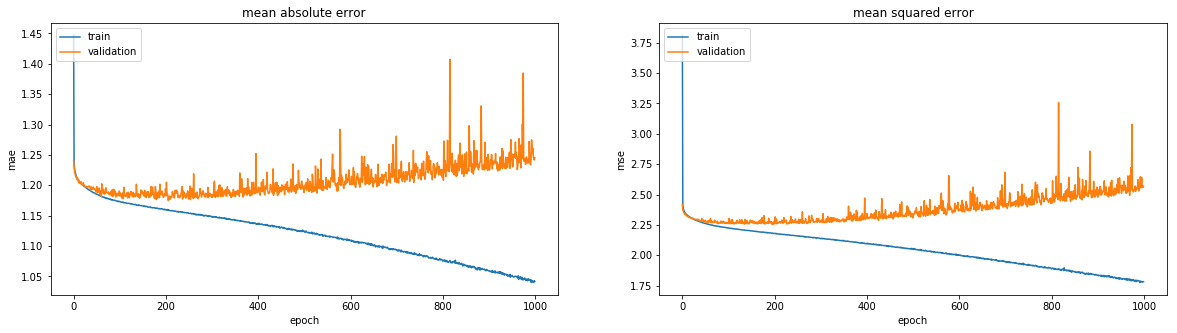

loss:  1.91
mae:  1.07
mse:  1.91


Evaluation on unseen data:


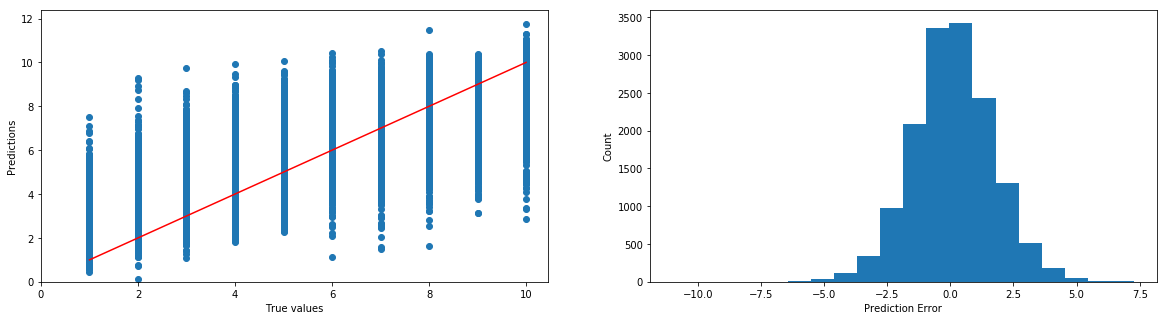

In [40]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 30
pd.options.display.width = 120
pd.options.display.float_format = '{:.3f}'.format

df = pd.read_csv("nndata_03.2019.csv", sep=",", header=None)

df = df.drop(df[df[0] == 0].index)
df = df.drop(df[df[15] == 0].index)
df = df.drop(df[df[15] < (df[0]-2*df[5])].index)
df = df.dropna()

df = df.reindex(np.random.permutation(df.index))

# print(df.describe().transpose())
# print(df)
# sns.pairplot(df, diag_kind="kde")

def parse_labels_and_features(data):
    labels = data[15]

    data = data.loc[:, 0:14]
    data.drop(data.columns[[5, 6, 13, 14]], axis=1, inplace=True)
    
    stats = data.describe()
    stats = stats.transpose()
    
    def norm(x):
        return (x - stats['mean']) / stats['std']    
    
    return norm(data).values, labels

def train_model(df):

    q90 = int(df[0].count() * 0.9)

    training_examples, training_labels = parse_labels_and_features(df[:q90])
    unseen_examples, unseen_labels = parse_labels_and_features(df[q90:])
    
    #print(training_examples)
    #print(training_labels)
    
    model = keras.Sequential([
        keras.layers.Dense(121, activation=tf.nn.relu, input_shape=[11]),
        keras.layers.Dense(242, activation=tf.nn.relu),
        keras.layers.Dense(242, activation=tf.nn.relu),
        keras.layers.Dense(121, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])
    
    model.compile(
        optimizer=tf.train.GradientDescentOptimizer(0.001), 
        loss='mse', 
        metrics=['mae', 'mse'])

    class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            if epoch % 100 == 0: print('')
            print('.', end='')    
    
    #early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    
    history = model.fit(
        training_examples, 
        training_labels, 
        epochs=1000, 
        batch_size=100, 
        validation_split = 0.2, verbose=0,
        callbacks=[PrintDot()])   # early_stop, 
    
    print('\n\nTraning results:')
    
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('mean absolute error')    
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('mean squared error')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    plt.show()
    
    loss, mae, mse = model.evaluate(training_examples, training_labels, verbose=0)
    print("loss: {:5.2f}".format(loss))    
    print("mae: {:5.2f}".format(mae))
    print("mse: {:5.2f}".format(mse))
    
    print('\n\nEvaluation on unseen data:')    
    unseen_predictions = model.predict(unseen_examples).flatten()
    
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)  
    plt.scatter(unseen_labels, unseen_predictions)
    plt.xlabel('True values')
    plt.ylabel('Predictions')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    plt.plot([1, 10], [1, 10], 'r')
    
    error = unseen_predictions - unseen_labels
    plt.subplot(1, 2, 2)  
    plt.hist(error, bins = 20)
    plt.xlabel("Prediction Error")
    plt.ylabel("Count")

train_model(df)